# COMP9414 Assignment 1
# Artificial Neural Networks
@author: Weng Xinn Chow (z5346077)

@date: 21st June 2024

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, mean_squared_error, mean_absolute_error

import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam, SGD
from sklearn.model_selection import RandomizedSearchCV
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

## Import dataset

In [2]:
filepath = "./AirQualityUCI _ Students.xlsx"
df = pd.read_excel(filepath)
# df.head()

### Initial data inspection

In [3]:
# # Check shape of dataframe
# print(df.shape)

In [4]:
# print(df.columns)

In [5]:
# df.info()

### Initial data cleansing

In [6]:
# Drop duplicates (if any)
df = df.drop_duplicates()

In [7]:
# Replace missing values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

In [8]:
# df.head(10)

In [9]:
# df.info()

## Initial Exploratory data analysis (EDA)

### Statistical summary

In [10]:
# # Range (min & max), mean, std deviation of variables
# df.describe()

Statistical data such as min, max and mean can be observed from the summary above. The range of variables are distributed widely, indicating the potential need of feature normalisation before training models.

### Missing data visualisation

In [11]:
# # Heatmap to visualise missing data
# plt.figure(figsize=(12,6))

# # Determine if values are null (True if null)
# missing_df = df.isnull()
# sns.heatmap(missing_df, cbar=False, cmap='rocket_r')

# plt.title('Missing Data Heatmap')
# plt.tight_layout()
# plt.show()

The heatmap is used to visualise missing data across each variable. It can be observed that NMHC(GT) has the largest amount of missing values compared to other variables. The effect of missing data is not negligible and therefore, it may be infeasible to drop those values for our model training.

### Distribution of target variables: CO(GT) & NOx(GT)

In [12]:
# def plot_distribution(data, columns, nrows, ncols, figsize, bins=100, kde=True, dpi=100, titles=None, suptitle=None, xlabels=None):
#     """
#     Plot respective distribution of specified columns.
#     """
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
#     axes = axes.flatten()
    
#     # Plot distribution for each feature
#     for i, col in enumerate(columns):
#         sns.histplot(data[col], bins=bins, kde=kde, ax=axes[i])
#         axes[i].set_title(f"Distribution of {col}")
#         axes[i].set_xlabel(col)
#         axes[i].set_ylabel("Frequency")
        
#     plt.tight_layout()
#     return fig, axes

In [13]:
# # Distribution plots of CO(GT) and NOx(GT)
# target_cols = ["CO(GT)", "NOx(GT)"]
# target_df = df[target_cols]
# fig, axes = plot_distribution(data=target_df, columns=target_cols, nrows=1, ncols=2, figsize=(18,6))
# plt.show()

The plots above show the distribution of respective target variables for classification and regression tasks (excluding missing values).

### Distribution of features

In [14]:
df2 = df.copy()

# Merge Datetime (datetime object)
df2['DateTime'] = pd.to_datetime(df2['Date'].astype(str) + ' ' + df2['Time'].astype(str))
df2.insert(1, 'DateTime', df2.pop('DateTime'))

# Drop Date and Time column
df2.drop(['Date', 'Time'], axis=1, inplace=True)
# df2.head()

In [15]:
# df2.info()

In [16]:
# feature_cols = [col for col in df2.columns if col != "CO(GT)" and col != "NOx(GT)"]
# print(feature_cols)

In [17]:
# # Plot distribution of features
# feature_df = df2[feature_cols]
# fig, axes = plot_distribution(data=feature_df, columns=feature_cols, nrows=4, ncols=3, figsize=(16,12))
# plt.show()

From the plots above, it can be clearly seen that the distributions of NMHC(GT), C6H6(GT), PT08.S3(NOx) are positively skewed. By analysing the distribution plots, it helps to determine the reasonable methods to handle missing values. 

## Data preprocessing & EDA

### Handling outliers and missing values

By considering the amount of missing data, it is infeasible to directly drop those values as they could contribute a significant effects towards the final output of the model. **Mean and median imputation** and **data interpolation** are used to handle the missing values. 

#### Mean and median imputation

As mentioned before, each variable have different skewness of distribution. Therefore, imputation of missing values are carried out based on their distribution skewness. If a feature has a normal (symmetric) distribution, mean imputation (replace missing values with mean) can be used. On the other hand, if it has a skewed distribution, it is generally more appropriate to use median imputation as median is more robust to potential outliers. 

In [18]:
# # Threshold to determine skewness threshold
# # Normal distribution if skewness < threshold
# threshold = 0.5
# df2_impute = df2.copy()
# for col in df2_impute.drop("DateTime", axis=1):
#     skewness = df2_impute[col].skew()
#     mean = df2_impute[col].mean()
#     median = df2_impute[col].median()
    
#     # Mean imputation if normal distribution
#     if abs(skewness) < threshold: 
#         df2_impute[col].fillna(mean, inplace=True)
#     # Median imputation if skewed distribution
#     else:
#         df2_impute[col].fillna(median, inplace=True)

In [19]:
# df2_impute.head(10)

In [20]:
# df2_impute.info()

In [21]:
# df2_impute.describe()

In [22]:
# # Distribution plots of CO(GT) and NO2(GT)
# # target_cols = ["CO(GT)", "NOx(GT)"]
# target_df = df2_impute[target_cols]
# fig, axes = plot_distribution(data=target_df, columns=target_cols, nrows=1, ncols=2, figsize=(18,6))
# plt.show()

In [23]:
# # Plot distribution of features
# feature_df = df2_impute[feature_cols]
# fig, axes = plot_distribution(data=feature_df, columns=feature_cols, nrows=4, ncols=3, figsize=(16,12))
# plt.show()

From the plots, it can be observed that the mean and median for corresponding variables has higher frequency, which is understandable as they are imputed to replace the missing data.

#### Interpolation

The dataset is recorded over intervals of time. Therefore, it is pertinent to use time data interpolation to fill the missing data. The method basically estimates the missing data based on the two adjacent data values. 

In [24]:
df2_interpolate = df2.copy()

# Set DateTime as index for interpolation
df2_interpolate.set_index('DateTime', inplace=True)
df2_interpolate.interpolate(method='time', inplace=True)

In [25]:
df2_interpolate.reset_index(inplace=True)
# df2_interpolate.head(10)

In [26]:
# df2_interpolate.info()

In [27]:
# df2_interpolate.describe()

In [28]:
# # Distribution plots of CO(GT) and NOx(GT)
# # target_cols = ["CO(GT)", "NO2(GT)"]
# target_df = df2_interpolate[target_cols]
# fig, axes = plot_distribution(data=target_df, columns=target_cols, nrows=1, ncols=2, figsize=(18,6))
# plt.show()

In [29]:
# # Plot distribution of features
# feature_df = df2_interpolate[feature_cols]
# fig, axes = plot_distribution(data=feature_df, columns=feature_cols, nrows=4, ncols=3, figsize=(16,12))
# plt.show()

In [30]:
# Use the interpolated data
# Drop DateTime (not continuous data)
df_ = df2_interpolate.copy()
df_.drop("DateTime", axis=1, inplace=True)

# # Use the imputed data
# # Drop DateTime (not continuous data)
# df_ = df2_impute.copy()
# df_.drop("DateTime", axis=1, inplace=True)

By comparing the results of two methods, data interpolation is used to handle missing values. Imputation is not suitable for time-series data and the result indicates potential bias towards mean and median values. 

### Correlation between features and target variables

In [31]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=100)
# axes = axes.flatten()

# # Correlation of CO(GT)
# sns.heatmap(df_.corr().drop("CO(GT)")[["CO(GT)"]], cmap="coolwarm", annot=True, ax=axes[0]) 
# axes[0].set_title("Correlation between CO(GT) and other variables")

# # Correlation of NOx(GT)
# sns.heatmap(df_.corr().drop("NOx(GT)")[["NOx(GT)"]], cmap="coolwarm", annot=True, ax=axes[1]) 
# axes[1].set_title("Correlation between NOx(GT) and other variables")

# plt.tight_layout()
# plt.show()

Correlation between features and target variables are plotted in the heatmaps above. They are useful for feature selection, in which those features with lower correlation can be treated as redundant data, can be removed from model training.

### Feature selection with random forests and correlation-filtering approach

A hybrid of correlation-filtering approach and random forest model (to determine feature importance) are used to select feature. By assigning a correlation threshold and an importance threshold, we can select features effectively based on their correlation with the corresponding target variable and their importance value.

In [32]:
# # Data used to train
# df_.head()

In [33]:
def feature_selection(task, df, corr_threshold=0.1, perm_threshold=0.01, random_state=42, test_size=0.3, n_estimators=100, max_depth=None):
    """
    Feature selection using the hybrid approach of correlation filtering and Random forest model. 
    Selected features should satisfy both threshold conditions.
    """
    # Classification task
    if task == 1:
        target = "CO(GT)"
    # Regression task
    else: target = "NOx(GT)"
    
    # Split train and test sets
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)
    
    # Normalise data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train a random forest regressor
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    rf.fit(X_train, y_train)
    
    # Get permutation importance of each feature 
    importances = permutation_importance(rf, X_test, y_test, random_state=42)
    
    # Create a relevant dataframe and sort by descending order
    feature_importances = pd.DataFrame({
        "feature": X.columns,
        "importance": importances.importances_mean
    }).sort_values(by="importance", ascending=False)
    
    print("Feature permutation importances:")
    print(feature_importances)
    
    # Compute correlation between features and the target variable and create dataframe
    corr = df.corr()[target].drop(target)
    feature_corr = corr.to_frame().reset_index()
    feature_corr.columns = ["feature", "correlation"]
    
    print(f"\nFeature correlations with {target}:")
    print(feature_corr)
    
    # Select features that exceed correlation threshold
    corr_features = corr[corr.abs() > corr_threshold].index.tolist()
    
    # Select features that exceed permutation importance threshold
    perm_features = X.columns[importances.importances_mean > perm_threshold]
    
    # Filter out features that don't exceed both threshold
    selected_features = list(set(corr_features).union(set(perm_features)))
    
    return feature_importances, feature_corr, selected_features

#### Classification task: CO

In [34]:
# Set parameters for feature selection
corr_threshold = 0.1
perm_threshold = 0.01
test_size = 0.3

In [35]:
# Select features based on Random forests and correlation with CO(GT)
importances1, corr1, selected1 = feature_selection(task=1, 
                                                  df=df_,
                                                  corr_threshold=corr_threshold, 
                                                  perm_threshold=perm_threshold, 
                                                  test_size=test_size)

Feature permutation importances:
          feature  importance
4         NOx(GT)    0.685849
3   PT08.S2(NMHC)    0.127466
7    PT08.S4(NO2)    0.089900
2        C6H6(GT)    0.067200
6         NO2(GT)    0.067147
0     PT08.S1(CO)    0.045799
11             AH    0.029536
8     PT08.S5(O3)    0.013575
1        NMHC(GT)    0.010562
9               T    0.009245
5    PT08.S3(NOx)    0.008634
10             RH    0.005370

Feature correlations with CO(GT):
          feature  correlation
0     PT08.S1(CO)     0.787535
1        NMHC(GT)     0.277825
2        C6H6(GT)     0.805365
3   PT08.S2(NMHC)     0.797853
4         NOx(GT)     0.790965
5    PT08.S3(NOx)    -0.661838
6         NO2(GT)     0.676904
7    PT08.S4(NO2)     0.549297
8     PT08.S5(O3)     0.767356
9               T     0.028419
10             RH     0.063494
11             AH     0.079203


In [36]:
# # Plot importances and correlations
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=100)
# axes = axes.flatten()

# sns.barplot(x="importance", y="feature", data=importances1, ax=axes[0])
# axes[0].set_title("Feature permutation importances")

# # Observe absolute values and sort by descending order
# corr1["correlation"] = corr1["correlation"].abs()
# corr1 = corr1.sort_values(by="correlation", ascending=False)
# sns.barplot(x="correlation", y="feature", data=corr1, ax=axes[1])
# axes[1].set_title("Feature correlations with CO(GT)")

# plt.tight_layout()
# plt.show()

In [37]:
print(f"Selected features for task 1:\n{selected1}")

Selected features for task 1:
['AH', 'NO2(GT)', 'PT08.S4(NO2)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'NOx(GT)', 'NMHC(GT)', 'PT08.S5(O3)', 'PT08.S1(CO)']


In [38]:
# Data with selected features only
df_1 = df_.loc[:, selected1 + ["CO(GT)"]]
# df_1.head()

# df_1.info()

Feature: T and RH are weakly correlated with the target, CO(GT) and their importance values computed from random forests model are considered low (as they didn't exceed the threshold), so they are eliminated.

#### Regression task: NOx

In [39]:
# Select features based on Random forests and correlation with NOx(GT)
importances2, corr2, selected2 = feature_selection(task=2, 
                                                  df=df_,
                                                  corr_threshold=corr_threshold, 
                                                  perm_threshold=perm_threshold, 
                                                  test_size=test_size)

Feature permutation importances:
          feature  importance
6         NO2(GT)    0.342008
5    PT08.S3(NOx)    0.205525
0          CO(GT)    0.138101
7    PT08.S4(NO2)    0.124562
9               T    0.047846
10             RH    0.032111
8     PT08.S5(O3)    0.026172
3        C6H6(GT)    0.013430
4   PT08.S2(NMHC)    0.009544
11             AH    0.008629
1     PT08.S1(CO)    0.007015
2        NMHC(GT)    0.002810

Feature correlations with NOx(GT):
          feature  correlation
0          CO(GT)     0.790965
1     PT08.S1(CO)     0.672578
2        NMHC(GT)     0.163453
3        C6H6(GT)     0.647824
4   PT08.S2(NMHC)     0.640303
5    PT08.S3(NOx)    -0.636793
6         NO2(GT)     0.768611
7    PT08.S4(NO2)     0.202550
8     PT08.S5(O3)     0.737645
9               T    -0.246834
10             RH     0.204182
11             AH    -0.127588


In [40]:
# # Plot importances and correlations
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=100)
# axes = axes.flatten()

# sns.barplot(x="importance", y="feature", data=importances2, ax=axes[0])
# axes[0].set_title("Feature permutation importances")

# # Observe absolute values and sort by descending order
# corr2["correlation"] = corr2["correlation"].abs()
# corr2 = corr2.sort_values(by="correlation", ascending=False)
# sns.barplot(x="correlation", y="feature", data=corr2, ax=axes[1])
# axes[1].set_title("Feature correlations with NOx(GT)")

# plt.tight_layout()
# plt.show()

In [41]:
print(f"Selected features for task 2:\n{selected2}")

Selected features for task 2:
['C6H6(GT)', 'CO(GT)', 'AH', 'PT08.S2(NMHC)', 'NMHC(GT)', 'PT08.S5(O3)', 'T', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S3(NOx)', 'RH', 'PT08.S1(CO)']


In [42]:
df_2 = df_.loc[:, selected2 + ["NOx(GT)"]]
# df_2.head()

# df_2.info()

No features are eliminated.

### Target label for classification task

In [43]:
# Determine threshold by calculating the mean of CO(GT)
mean_threshold = df["CO(GT)"].mean()

# Label target: 1 if > threshold, 0 otherwise
df_1["target"] = (df_1["CO(GT)"] > mean_threshold).astype(int) 
df_1.drop("CO(GT)", axis=1, inplace=True)
# df_1.head()

### Distribution of processed target variables

In [44]:
# Change column name of target for regression task (consistency)
df_2.rename(columns={"NOx(GT)": "target"}, inplace=True)
# df_2.head()

In [45]:
# # Plot distribution of target variables after data preprocessing for 
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=100)
# axes = axes.flatten()

# # Data label for classification task
# sns.countplot(x="target", data=df_1, ax=axes[0])
# axes[0].set_title("Distribution of target label: CO2(GT) > mean threshold")
# axes[0].set_xlabel("CO2(GT) > mean threshold")
# axes[0].set_ylabel("Frequency")

# # Target data for regression task
# sns.histplot(df_2["target"], bins=100, kde=True, ax=axes[1])
# axes[1].set_title(f"Distribution of NOx(GT)")
# axes[1].set_xlabel("NOx(GT)")
# axes[1].set_ylabel("Frequency")

# plt.tight_layout()
# plt.show()

### Data normalisation & train-test split

In [46]:
def normalised_train_test_split(task, df, test_size=0.2, random_state=0):
    """
    Normalise the given data and split into train, validation and test sets according to the specified test size proportion.
    """
    # Split data into X (features) and y (target)
    X = df.drop("target", axis=1)
    y = df["target"]
    print(f"Shape of X, y: {X.shape}, {y.shape}")
    
    # Normalise features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Task 1 split
    # Split train, validation, test sets
    if task == 1:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
    # Task 2 split
    else: 
        train_size = int((1 - (test_size)) * len(df))
        val_size = int(test_size * train_size)
        # Validation set comes from the partitioned train split
        train_size -= val_size
        test_size = int(test_size * len(df))
        
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_val = X[train_size:train_size+val_size]
        y_val = y[train_size:train_size+val_size]
        X_test = X[train_size+val_size:]
        y_test = y[train_size+val_size:]
        
    return X_train, X_val, X_test, y_train, y_val, y_test

In [47]:
# Set parameters for normalisation and train test split
test_size=0.2

#### Classification task

In [48]:
# Classification data
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = normalised_train_test_split(task=1, df=df_1, test_size=test_size)

Shape of X, y: (8358, 10), (8358,)


In [49]:
print(f"Train set shape: {X_train1.shape}, {y_train1.shape}")
print(f"Validation set shape: {X_val1.shape}, {y_val1.shape}")
print(f"Test set shape: {X_test1.shape}, {y_test1.shape}")

Train set shape: (5348, 10), (5348,)
Validation set shape: (1338, 10), (1338,)
Test set shape: (1672, 10), (1672,)


#### Regression task

In [50]:
# Regression data
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = normalised_train_test_split(task=2, df=df_2, test_size=test_size)

Shape of X, y: (8358, 12), (8358,)


In [51]:
print(f"Train set shape: {X_train2.shape}, {y_train2.shape}")
print(f"Validation set shape: {X_val2.shape}, {y_val2.shape}")
print(f"Test set shape: {X_test2.shape}, {y_test2.shape}")

Train set shape: (5349, 12), (5349,)
Validation set shape: (1337, 12), (1337,)
Test set shape: (1672, 12), (1672,)


## Classification task with neural network

### Design of neural network (Baseline classifier)

In [52]:
def define_model(input_shape, num_layers, num_units, activations, loss, metrics, optimizer="adam", dropout_rate=None):
    """
    Define the nueral network according to the specified input dimension, number of layers, number of units per layer, 
    activation functions across each layer, loss function and metrics, optimisers across each layer and dropout rate.
    """
    # Define a sequential model
    model = Sequential()
    
    # Add layers to the model
    # Number of layers does not include input layer
    for i in range(num_layers): 
        # Output layer
        if i == num_layers - 1:
            model.add(Dense(1, activation=activations["output"]))
        # First hidden layer
        elif i == 0:
            model.add(Dense(num_units, input_shape=input_shape, activation=activations["hidden"]))
            num_units //= 2
            # Apply dropout for regularisation
            if dropout_rate is not None:
                model.add(Drop(rate=dropout_level))
        # Subsequent hidden layers
        else:
            model.add(Dense(num_units, activation=activations["hidden"]))
            num_units //= 2
            # Apply dropout for regularisation
            if dropout_rate is not None:
                model.add(Drop(rate=dropout_level))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [53]:
# Define parameters for baseline classifier
num_layers1 = 3
num_units1 = 16
activations1 = {"hidden": "relu", "output": "sigmoid"}
loss1 = "binary_crossentropy"
# optimizer1 = "sgd"
optimizer1 = "adam"
metrics1 = ["accuracy"]

In [54]:
# # Train the baseline classifier
# baseline_classifier = define_model(input_shape=(X_train1.shape[1],),
#                                    num_layers=num_layers1, 
#                                    num_units=num_units1, 
#                                    activations=activations1,
#                                    loss=loss1, 
#                                    optimizer=optimizer1, 
#                                    metrics=metrics1)

# Set training parameters
epochs = 100
batch_size = 16

# # Train the model
# baseline_classifier.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size)

In [55]:
# baseline_classifier.summary()

### Hyperparameter-tuning

Parameters for neural network training including number of units per hidden layer, and optimiser (SGD, Adam) are tuned using a neural network based on the designed baseline model, which has 1 input layer, 2 hidden layers and 1 output layer. The tuned model is trained on 100 epochs, with batch size of 16. 

In [56]:
def hp_model(hp, params, input_shape, activations, loss, metrics):
    """ 
    Define the neural network (1 input layer, 2 hidden layers and 1 output layer) for hyperparameter-tuning.
    """
    # Define a sequential model
    model = keras.Sequential()
    
    # Define number of units for the first hidden layer
    num_units_first_hidden_layer = hp.Choice("num_units", params["num_units"])
    
    # Add first hidden layer
    model.add(Dense(units=num_units_first_hidden_layer, 
                    input_shape=input_shape, 
                    activation=activations["hidden"]))
    
    # Add second hidden layer
    model.add(Dense(units=num_units_first_hidden_layer // 2, 
                    input_shape=input_shape, 
                    activation=activations["hidden"]))
    
    # Add output layer
    model.add(Dense(1, activation=activations["output"]))
    # Compile the model
    
    model.compile(optimizer=hp.Choice("optimizer", params["optimizer"]), loss=loss, metrics=metrics)
    return model

def build_hp_model1(hp):
    """
    Build hyperparameter-tuning classifier (task 1).
    """
    # Specified input shape
    input_shape = (X_train1.shape[1],)

    # Hyperparameters to be tuned
    params = {
        "num_units": [16, 32], 
        "optimizer": ["adam", "sgd"],
    }
    
    # Set fixed model training parameters
    activations = {"hidden": "relu", "output": "sigmoid"}
    loss = "binary_crossentropy"
    metrics = ["accuracy"]
    
    return hp_model(hp, params, input_shape, activations, loss, metrics)

In [57]:
def hyperparameter_tuning(task, max_trials=5, executions_per_trial=3, epochs=50, validation_split=0.2):
    """
    Tune hyperparameters for the defined neural network.
    """
    if task == 1:
        hypermodel = build_hp_model1
        X_train = X_train1
        y_train = y_train1
    else: 
        hypermodel = build_hp_model2
        X_train = X_train1
        y_train = y_train1
        
    # Tune with random search
    rs = RandomSearch(hypermodel=build_hp_model1,
                      objective="val_accuracy",
                      max_trials=max_trials, # max total number of trials
                      executions_per_trial=executions_per_trial,
                      directory="hp_dir",
                      project_name=f"t{task}_hp")
    
    batch_size = 16
    # Hyperparameter tuning using keras tuner random search
    rs.search(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    
    # Get the optimal hyperparameters
    best_hps=rs.get_best_hyperparameters(num_trials=1)[0]
    
    return best_hps

In [58]:
# Tune number of units per layer and optimiser
best_hps1 = hyperparameter_tuning(task=1)

print(best_hps1.get("num_units"))
print(best_hps1.get("optimizer"))

Reloading Tuner from hp_dir\t1_hp\tuner0.json
32
adam


### Model training and validation

In [59]:
def evaluate_model(X_train, y_train, X_val, y_val, num_layers, num_units, activations, loss, optimizer, metrics, epochs, \
                   batch_size):
    """
    Train and evaluate the neural network
    """
    # Define neural network and train the model
    model = define_model(input_shape=(X_train.shape[1],), 
                         num_layers=num_layers, 
                         num_units=num_units, 
                         activations=activations,
                         loss=loss, 
                         optimizer=optimizer, 
                         metrics=metrics)
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    
    # Evaluate the model
    train_result = model.evaluate(X_train, y_train)
    val_result = model.evaluate(X_val, y_val)
    
    return model, history, train_result, val_result

In [60]:
# Train and validate the model using tuned parameters
# Minus 2 to fulfil the condition: # parameters < (# samples / 10) - prevent overfitting
num_units1 = best_hps1.get("num_units") - 2
optimizer1 = best_hps1.get("optimizer")

model1, history1, train_result1, val_result1 = evaluate_model(X_train=X_train1, 
                                                            y_train=y_train1, 
                                                            X_val=X_val1, 
                                                            y_val=y_val1, 
                                                            num_layers=num_layers1, 
                                                            num_units=num_units1, 
                                                            activations=activations1,
                                                            loss=loss1, 
                                                            optimizer=optimizer1, 
                                                            metrics=metrics1,
                                                            epochs=epochs, 
                                                            batch_size=batch_size) 

C:\Users\wengx\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6361 - loss: 0.5897 - val_accuracy: 0.8677 - val_loss: 0.3058
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8904 - loss: 0.2752 - val_accuracy: 0.8864 - val_loss: 0.2704
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9040 - loss: 0.2468 - val_accuracy: 0.8924 - val_loss: 0.2609
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9060 - loss: 0.2464 - val_accuracy: 0.8961 - val_loss: 0.2556
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9029 - loss: 0.2477 - val_accuracy: 0.9021 - val_loss: 0.2510
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9099 - loss: 0.2252 - val_accuracy: 0.9036 - val_loss: 0.2466
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9117 - loss: 0.2275 - val_accuracy: 0.9013 - val_loss: 0.2458
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9119 - loss: 0.2296 - val_accu

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9258 - loss: 0.1797 - val_accuracy: 0.9066 - val_loss: 0.2209
Epoch 52/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9243 - loss: 0.1853 - val_accuracy: 0.9103 - val_loss: 0.2210
Epoch 53/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9327 - loss: 0.1710 - val_accuracy: 0.9096 - val_loss: 0.2235
Epoch 54/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.1808 - val_accuracy: 0.9081 - val_loss: 0.2223
Epoch 55/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9263 - loss: 0.1799 - val_accuracy: 0.9081 - val_loss: 0.2193
Epoch 56/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.1717 - val_accuracy: 0.9088 - val_loss: 0.2216
Epoch 57/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9298 - loss: 0.1717 - val_accuracy: 0.9096 - val_loss: 0.2222
Epoch 58/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9319 - loss: 0.1703 - val_accuracy:

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1651
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9111 - loss: 0.2093


In [61]:
_, train_acc1 = train_result1
_, val_acc1 = val_result1

print(f"Train accuracy: {train_acc1}")
print(f"Validation accuracy: {val_acc1}")

Train accuracy: 0.9371727705001831
Validation accuracy: 0.908071756362915


In [62]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,435 (9.52 KB)

 Trainable params: 811 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,624 (6.35 KB)

In [63]:
# # Plot loss and accuracy during training
# plt.figure(figsize=(18,6), dpi=100)

# # Plot loss for training and validation
# plt.subplot(121)
# plt.title("Classification task - Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.plot(history1.history["loss"], label="Training loss")
# plt.plot(history1.history["val_loss"], label="Validation loss")
# plt.legend()

# # Plot accuracy for training and validation
# plt.subplot(122)
# plt.title("Classification task - Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")

# plt.plot(history1.history["accuracy"], label="Training accuracy")
# plt.plot(history1.history["val_accuracy"], label="Validation accuracy")
# plt.legend()

# plt.tight_layout()
# plt.show()

### Model testing and evaluation

#### Confusion matrix

In [64]:
# Predict label
y_pred1 = (model1.predict(X_test1)> 0.5).astype("int32").flatten()

# Compute confusion matrix
cm1 = confusion_matrix(y_test1, y_pred1)

# Convert into dataframe
indices = ["False positives", "True negatives"]
columns = ["True positives", "False negatives"]
cm1 = pd.DataFrame(cm1, columns=columns, index=indices)
cm1

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,True positives,False negatives
False positives,929,72
True negatives,55,616


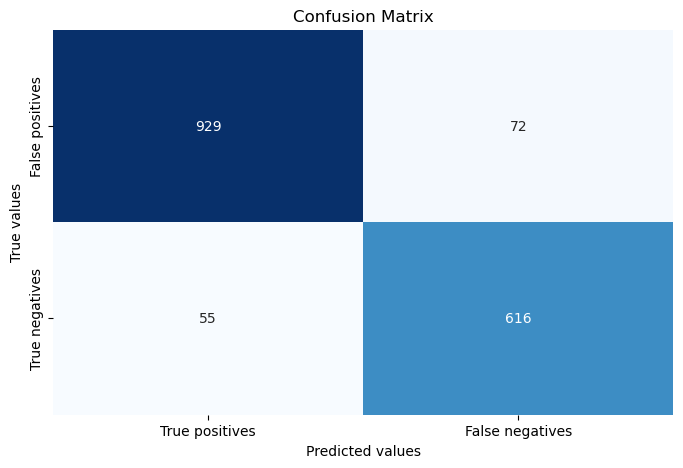

In [65]:
# Plot confusion matrix
plt.figure(figsize=(8,5), dpi=100)
sns.heatmap(cm1, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion Matrix')
plt.show()

#### Precision and accuracy

In [66]:
# Precision: tp/(tp+fp)
# Precision: Evaluate how many predicted values are labelled correctly
precision1 = precision_score(y_pred1, y_test1)

# Accuracy
accuracy1 = accuracy_score(y_pred1, y_test1)

# Number of samples
num_samples1 = len(y_test1)

acc_pc = pd.DataFrame({
    "Accuracy": accuracy1, 
    "Precision": precision1, 
    "Number of Samples": num_samples1
}, index=["CO(GT) classification"])
acc_pc

,Accuracy,Precision,Number of Samples
CO(GT) classification,0.924043,0.918033,1672


## Regression task with neural network

### Design of neural network (Baseline regressor)

In [67]:
# Define parameters for baseline classifier
num_layers2 = 3
num_units2 = 16
activations2 = {"hidden": "relu", "output": "linear"}
loss2 = "mean_squared_error"
# optimizer2 = "sgd"
optimizer2 = "adam"
metrics2 = ["mae"]

In [68]:
# baseline_regressor = define_model(input_shape=(X_train2.shape[1],),
#                                    num_layers=num_layers2, 
#                                    num_units=num_units2, 
#                                    activations=activations2,
#                                    loss=loss2, 
#                                    optimizer=optimizer2, 
#                                    metrics=metrics2)

# # Train the model
# baseline_regressor.fit(X_train2, y_train2, epochs=epochs, batch_size=batch_size)

In [69]:
# baseline_regressor.summary()

### Hyperparameter tuning

Parameters for neural network training including number of units per hidden layer, and optimiser (SGD, Adam) are tuned using a neural network based on the designed baseline model, which has 1 input layer, 2 hidden layers and 1 output layer. The tuned model is trained on 100 epochs, with batch size of 16.

In [70]:
def build_hp_model2(hp):
    """
    Build hyperparameter-tuning regressor (task 2).
    """
    # Specified input shape
    input_shape = (X_train2.shape[1],)

    # Hyperparameters to be tuned
    params = {
        "num_units": [16, 32], 
        "optimizer": ["adam", "sgd"],
    }
    
    # Set fixed model training parameters
    activations = {"hidden": "relu", "output": "linear"}
    loss = "mean_squared_error"
    metrics = ["mae"]
    
    return hp_model(hp, params, input_shape, activations, loss, metrics)

In [71]:
# Tune number of units per layer and optimiser
best_hps2 = hyperparameter_tuning(task=2)

print(best_hps2.get("num_units"))
print(best_hps2.get("optimizer"))

Reloading Tuner from hp_dir\t2_hp\tuner0.json
32
adam


### Model training and validation

In [72]:
# Train and validate the model using tuned parameters
# Minus 4 to fulfil the condition: # parameters < (# samples / 10) - prevent overfitting
num_units2 = best_hps2.get("num_units") - 4
optimizer2 = best_hps2.get("optimizer")

model2, history2, train_result2, val_result2 = evaluate_model(X_train=X_train2, 
                                                              y_train=y_train2, 
                                                              X_val=X_val2, 
                                                              y_val=y_val2, 
                                                              num_layers=num_layers2, 
                                                              num_units=num_units2, 
                                                              activations=activations2,
                                                              loss=loss2, 
                                                              optimizer=optimizer2, 
                                                              metrics=metrics2,
                                                              epochs=epochs, 
                                                              batch_size=batch_size)

Epoch 1/100


C:\Users\wengx\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 54234.9258 - mae: 177.7900 - val_loss: 210792.8281 - val_mae: 379.2927
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 40231.0430 - mae: 146.0432 - val_loss: 132959.6719 - val_mae: 306.6071
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16368.6494 - mae: 90.2930 - val_loss: 95038.0156 - val_mae: 261.1535
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12973.1445 - mae: 82.2238 - val_loss: 82697.2422 - val_mae: 240.5994
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10412.4766 - mae: 74.7993 - val_loss: 64999.4297 - val_mae: 209.5857
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9127.5771 - mae: 69.1251 - val_loss: 48656.1992 - val_mae: 175.1418
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7043.6426 - mae: 60.1293 - val_loss: 35389.9609 - val_mae: 141.6362
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5544.8428 - mae: 53.5925 - val_loss: 24

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2540.7393 - mae: 34.8264 - val_loss: 18543.4629 - val_mae: 115.8401
Epoch 52/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2518.7148 - mae: 34.4340 - val_loss: 18429.1406 - val_mae: 116.4621
Epoch 53/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2417.5264 - mae: 33.5728 - val_loss: 18634.0156 - val_mae: 117.0574
Epoch 54/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2591.7412 - mae: 34.8846 - val_loss: 18347.5332 - val_mae: 116.0679
Epoch 55/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2470.5408 - mae: 34.4962 - val_loss: 18542.2461 - val_mae: 116.1893
Epoch 56/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2406.9844 - mae: 33.9077 - val_loss: 18299.4219 - val_mae: 115.4680
Epoch 57/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2329.8281 - mae: 33.5252 - val_loss: 19019.4023 - val_mae: 117.6817
Epoch 58/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2439.9360 - mae: 33.9490 - val_loss: 1874

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1113.2896 - mae: 22.8487
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16017.8301 - mae: 104.0527


In [73]:
_, train_mae2 = train_result2
_, val_mae2 = val_result2

print(f"Train MAE: {train_mae2}")
print(f"Validation MAE: {val_mae2}")

Train MAE: 31.730012893676758
Validation MAE: 112.06328582763672


In [74]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 28)                  │             364 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 14)                  │             406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,357 (9.21 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,572 (6.14 KB)

In [75]:
# # Plot loss and accuracy during training
# plt.figure(figsize=(18,6), dpi=100)

# # Plot loss for training and validation
# plt.subplot(121)
# plt.title("Regression task - Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.plot(history2.history["loss"], label="Training loss")
# plt.plot(history2.history["val_loss"], label="Validation loss")
# plt.legend()

# # Plot accuracy for training and validation
# plt.subplot(122)
# plt.title("MLP Validation Phase - Actual vs Estimated NOx(GT) Values")
# plt.xlabel("Sample Index")
# plt.ylabel("NOx(GT) Value")


# # Predict target value
# y_val_pred2 = model2.predict(X_val2).flatten()
# # Drop index to make both validation sets consistent
# y_val_plot2 = y_val2.reset_index(drop=True)

# plt.plot(y_val_plot2, label="Actual")
# plt.plot(y_val_pred2, label="Predict")
# plt.legend()

# plt.tight_layout()
# plt.show()

### Model testing and evaluation

In [76]:
# Predict target values on test set
y_pred2 = model2.predict(X_test2).flatten()

# mse
mse2 = mean_squared_error(y_test2, y_pred2)
# root mse
rmse2 = mse2 ** 0.5

# mae
mae2 = mean_absolute_error(y_test2, y_pred2)

num_samples2 = len(y_test2)

rmse_mae = pd.DataFrame({
    "RMSE": rmse2, 
    "MAE": mae2, 
    "Number of Samples": num_samples2
}, index=["Estimation of NOx(GT)"])
rmse_mae

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,RMSE,MAE,Number of Samples
Estimation of NOx(GT),194.260311,176.720118,1672


## Generalisation

### Classification NN model

In [77]:
filepath = "Generalization Dataset.xlsx"
df = pd.read_excel(filepath)

# Drop duplicates (if any)
df = df.drop_duplicates()

# Replace missing values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

df2 = df.copy()

# Merge Datetime (datetime object)
df2['DateTime'] = pd.to_datetime(df2['Date'].astype(str) + ' ' + df2['Time'].astype(str))
df2.insert(1, 'DateTime', df2.pop('DateTime'))

# Drop Date and Time column
df2.drop(['Date', 'Time'], axis=1, inplace=True)
# df2.head()

df2_interpolate = df2.copy()

# Set DateTime as index for interpolation
df2_interpolate.set_index('DateTime', inplace=True)
df2_interpolate.interpolate(method='time', inplace=True)
df2_interpolate.reset_index(inplace=True)

# Use the interpolated data
# Drop DateTime (not continuous data)
df_ = df2_interpolate.copy()
df_.drop("DateTime", axis=1, inplace=True)

df_1 = df_.loc[:, selected1 + ["CO(GT)"]]
df_2 = df_.loc[:, selected2 + ["NOx(GT)"]]

# Label target: 1 if > threshold, 0 otherwise
df_1["target"] = (df_1["CO(GT)"] > mean_threshold).astype(int) 
df_1.drop("CO(GT)", axis=1, inplace=True)

# Change column name of target for regression task (consistency)
df_2.rename(columns={"NOx(GT)": "target"}, inplace=True)

X_gen1 = df_1.drop("target", axis=1)
# Normalise features
scaler = StandardScaler()
X_gen1 = scaler.fit_transform(X_gen1)
y_gen1 = df_1['target']

X_gen2 = df_2.drop("target", axis=1)
# Normalise features
scaler = StandardScaler()
X_gen2 = scaler.fit_transform(X_gen2)
y_gen2 = df_2['target']

In [78]:
# Predict label
y_pred1 = (model1.predict(X_gen1)> 0.5).astype("int32").flatten()

# Compute confusion matrix
cm1 = confusion_matrix(y_gen1, y_pred1)

# Convert into dataframe
indices = ["False positives", "True negatives"]
columns = ["True positives", "False negatives"]
cm1 = pd.DataFrame(cm1, columns=columns, index=indices)
cm1

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,True positives,False negatives
False positives,472,34
True negatives,48,318


In [79]:
# Precision: tp/(tp+fp)
# Precision: Evaluate how many predicted values are labelled correctly
precision1 = precision_score(y_pred1, y_gen1)

# Accuracy
accuracy1 = accuracy_score(y_pred1, y_gen1)

# Number of samples
num_samples1 = len(y_gen1)

acc_pc = pd.DataFrame({
    "Accuracy": accuracy1, 
    "Precision": precision1, 
    "Number of Samples": num_samples1
}, index=["CO(GT) classification"])
acc_pc

,Accuracy,Precision,Number of Samples
CO(GT) classification,0.905963,0.868852,872


### Regression NN model

In [80]:
# Predict target values on test set
y_pred2 = model2.predict(X_gen2).flatten()

# mse
mse2 = mean_squared_error(y_gen2, y_pred2)
# root mse
rmse2 = mse2 ** 0.5

# mae
mae2 = mean_absolute_error(y_gen2, y_pred2)

num_samples2 = len(y_gen2)

rmse_mae = pd.DataFrame({
    "RMSE": rmse2, 
    "MAE": mae2, 
    "Number of Samples": num_samples2
}, index=["Estimation of NOx(GT)"])
rmse_mae

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,RMSE,MAE,Number of Samples
Estimation of NOx(GT),110.275677,78.084246,872
